# Neural Network for Text Reviews - using full data set and adjusted class weights

In this notebook, the full review set is input to a range of neural network models using balanced class_weights. Class weights need to be balanced as there are many more positive reviews(majority class - zero) than negative reviews(minority class - one). 

* Section 1 - Import libraries and dataset
* Section 2 - Data exploration and preprocessing
* Section 3 - Creating word embeddings
* Section 4 - Shallow fully connected network
* Section 5 - Single dense layer network
* Section 6 - Multi-layer dense network
* Section 7 - Convolutional network
* Section 8 - Recurrent network
* Section 9 - LSTM
* Section 10 - GRU
* Section 11 - Bidirectional 
* Section 12 - Stacked bidirectional
* Section 13 - Summary
* Section 14 - Hyperparameter tuning

Datasets needed to run notebook:

* fulldatasetcleaned.csv

Note: 
* Run in Python 3.6 or 3.7 environment.
* Also Numpy Version 1.19 (not the latest)

# Section 1: Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import full dataset
df = pd.read_csv("fulldatasetcleaned.csv")

In [3]:
df.shape

(10407, 6)

In [4]:
df.head()

,Unnamed: 0,Category,Town,Rating,all_text,cleaned
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...
1,1,Accommodation,Bognor,1,Horrendous noise Oyster Bay In Oyster Bay. Oh ...,horrendous noise oh dear poor sound insulation...
2,2,Accommodation,Bognor,5,Perfect festive few days! Arrived on 27th dec ...,perfect festive day arrived dec night festive ...
3,3,Accommodation,Bognor,5,Christmas Just got home a few days ago from o...,christmas got home day ago first christmas awa...
4,4,Accommodation,Bognor,4,"Butlins xmas Went for Xmas break for 4 nights,...",christmas went christmas break night included ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10407 non-null  int64 
 1   Category    10407 non-null  object
 2   Town        10407 non-null  object
 3   Rating      10407 non-null  int64 
 4   all_text    10407 non-null  object
 5   cleaned     10407 non-null  object
dtypes: int64(2), object(4)
memory usage: 488.0+ KB


In [6]:
# Convert rating to 1 or zero as before (1 for reviews rated 1 or 2 and zero for those rated 4 or 5. Drop those rated 3)
df = df[df["Rating"] != 3]
df.replace([1,2], 1, inplace = True)
df.Rating.replace([4,5], 0, inplace = True)

# Section 2: Data Exploration and Preparation

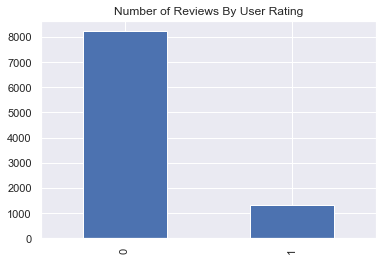

In [7]:
# Plot the value counts for each rating
ax = df['Rating'].value_counts().sort_index().plot.bar(title = "Number of Reviews By User Rating")

In [8]:
# Value counts
df.Rating.value_counts()

0    8229
1    1301
Name: Rating, dtype: int64

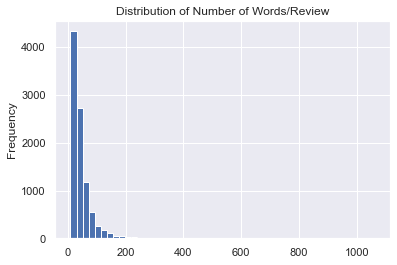

In [9]:
# Plot the distribution of review length in characters
ax = df["cleaned"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Review")

In [10]:
# Find maximum , minimum, mean, median review length in words/tokens
print(df.cleaned.str.split().apply(len).max())
print(df.cleaned.str.split().apply(len).min())
print(df.cleaned.str.split().apply(len).mean())
print(df.cleaned.str.split().apply(len).median())

1062
9
44.94554039874082
33.0


In [11]:
X = df["cleaned"]
y = df.Rating

In [12]:
# Split into training and validation sets, stratify on y, so the split of zero and one rated items between training and validation sets reflects the overall dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train,test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [13]:
print(X_train.shape, X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(5718,) (1906,) (1906,) (5718,) (1906,) (1906,)


In [14]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0    4937
1     781
Name: Rating, dtype: int64
0    1646
1     260
Name: Rating, dtype: int64
0    1646
1     260
Name: Rating, dtype: int64


# Section 3: Create Word Embeddings and Metrics Functions

## Preprocessing of each dataset

In [15]:
# Initialize and fit the tokenizer, which sets text to lower case, removes punctuation and tokenizes. Num_words is maximum
# number of words to keep

num_words = 10000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [16]:
with open('tokenizer2.pickle','wb') as handle:
    pickle.dump(tokenizer,handle,4)

In [17]:
# Examine words and counts of each word - uncomment to run
#print(tokenizer.word_counts)

In [18]:
# Get word plus unique ID in order of the highest frequency words descending - uncomment to run
#print(tokenizer.word_index)

In [19]:
# Get a list of index words for each word in the index
index_word = {v:k for k,v in tokenizer.word_index.items()}

In [20]:
# Create word sequences from the text
X_train_s = tokenizer.texts_to_sequences(X_train)
X_val_s = tokenizer.texts_to_sequences(X_val)
X_test_s = tokenizer.texts_to_sequences(X_test)

In [21]:
# Size of the dictionary (add 1 for zeroth index) - number of words in the dictionary 
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

12346

In [22]:
# Examine two padded review sequences to show different lengths for each review
print(X_train_s[0])

[4, 999, 324, 145, 332, 999, 109, 68, 14, 258, 247, 223, 28, 7, 836, 145, 3, 7005, 84, 5352, 1, 114, 154, 20, 1, 150, 223, 72, 23, 112, 3, 3, 1220, 13]


In [23]:
# Pad the vectors to consistent length. Padding to end of review and cutting long reviews at the end on the assumption 
# that more information will be contained at the front of the review rather than the end.
maxlen = 100

X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=maxlen, padding="post", truncating="post", value=0.0)
X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=maxlen, padding="post", truncating="post", value=0.0 )
X_test_w = pad_sequences(np.array(X_test_s,dtype = "object"), maxlen = maxlen, padding = "post",truncating = "post",value = 0.0)

In [24]:
# Show padded sequences
print(X_train_w[0])

[   4  999  324  145  332  999  109   68   14  258  247  223   28    7
  836  145    3 7005   84 5352    1  114  154   20    1  150  223   72
   23  112    3    3 1220   13    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [25]:
# Confusion Matrix function

def class_conf(y_val,y_pred_class):
    classification = classification_report(y_val, y_pred_class)
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    print(classification)  

In [54]:
# Metrics function

def metric_results(y_val,y_pred_class):
    accuracy = accuracy_score(y_val, y_pred_class)
    rocauc = roc_auc_score(y_val,y_pred_class)
    precision = precision_score(y_val, y_pred_class, average='binary')
    recall = recall_score(y_val, y_pred_class, average='binary')
    f1 = f1_score(y_val, y_pred_class, average='binary')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

# Section 4: Simple Perceptron - no hidden layers

In [27]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([0.57909662, 3.66069142])

In [87]:
# Set parameters
input_dim = vocabulary_size
output_dim = 16
input_length = 100
batch_size = 16
epochs = 10
class_weights = {0:0.58168871,
                 1:3.56039851}

In [88]:
# Simple model with embedding layer and no hidden dense layer, passing the embedding layer to the first layer of the model
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [89]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           197536    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1601      
Total params: 199,137
Trainable params: 199,137
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 
# Doesn't work due to compatability issues with graphviz and pydot so models visualised on Colab notebook

In [91]:
# The model will use earlystopping if the valuation loss doesn't decrease after 3 epochs
output_dir = 'model_output/simpleNN_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [92]:
# Model using keras embeddings
history = model.fit(X_train_w,y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/10
358/358 - 1s - loss: 0.5426 - accuracy: 0.8639 - val_loss: 0.2332 - val_accuracy: 0.9407
Epoch 2/10
358/358 - 0s - loss: 0.1615 - accuracy: 0.9622 - val_loss: 0.1409 - val_accuracy: 0.9591
Epoch 3/10
358/358 - 0s - loss: 0.0729 - accuracy: 0.9829 - val_loss: 0.0958 - val_accuracy: 0.9675
Epoch 4/10
358/358 - 0s - loss: 0.0412 - accuracy: 0.9920 - val_loss: 0.0889 - val_accuracy: 0.9669
Epoch 5/10
358/358 - 0s - loss: 0.0254 - accuracy: 0.9970 - val_loss: 0.0852 - val_accuracy: 0.9664
Epoch 6/10
358/358 - 0s - loss: 0.0166 - accuracy: 0.9984 - val_loss: 0.0807 - val_accuracy: 0.9685
Epoch 7/10
358/358 - 0s - loss: 0.0113 - accuracy: 0.9990 - val_loss: 0.0884 - val_accuracy: 0.9648
Epoch 8/10
358/358 - 0s - loss: 0.0078 - accuracy: 0.9997 - val_loss: 0.0858 - val_accuracy: 0.9690
Epoch 9/10
358/358 - 0s - loss: 0.0052 - accuracy: 0.9998 - val_loss: 0.0882 - val_accuracy: 0.9690


In [93]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Validation Accuracy:  0.9690


In [94]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

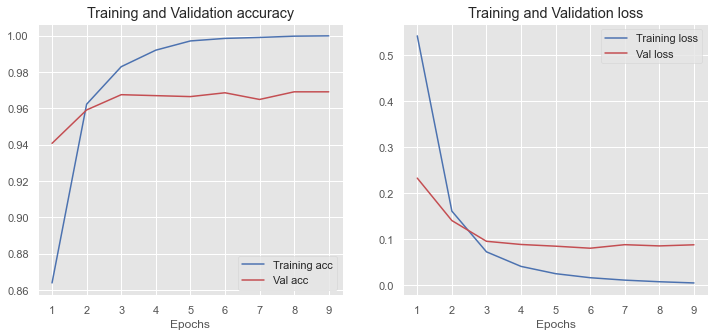

In [95]:
plot_history(history)

In [96]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.03.hdf5")

In [97]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [98]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.006997168],[0],0
1,[0.0044840276],[0],0
2,[0.004755825],[0],0
3,[0.91838026],[1],1
4,[0.9749714],[1],1


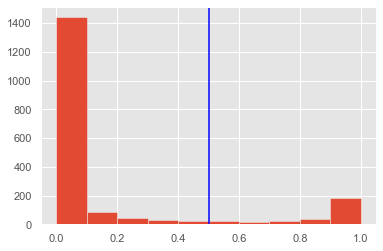

In [99]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1646
           1       0.85      0.93      0.89       260

    accuracy                           0.97      1906
   macro avg       0.92      0.95      0.93      1906
weighted avg       0.97      0.97      0.97      1906



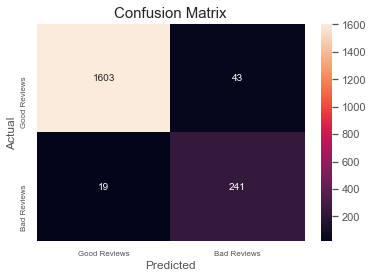

In [100]:
# Print metrics
class_conf(y_val,y_pred_class)

In [101]:
# Summarised results
simple_model = metric_results(y_val,y_pred_class)
simple_model

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.967471,0.848592,0.926923,0.886029,0.9504


In [102]:
# What it got wrong
not_correct = ydf[ydf.y != ydf.y_pred_class]
not_correct.head()

,y_prob,y_pred_class,y
39,[0.775072],[1],0
43,[0.97972584],[1],0
59,[0.7959802],[1],0
60,[0.9390029],[1],0
76,[0.2339651],[0],1


In [103]:
X_val.iloc[39]

'could refurbishment I coming since small child granted not fit much quaint charm not think chessington world adventure thorpe park place enjoy kid fun slot machine something age le'

In [105]:
# Where the model STRONGLY predicted a bad review but was actually rated as good by user
ydf[(ydf.y == 0) & (ydf.y_prob> 0.9)].head()

,y_prob,y_pred_class,y
43,[0.97972584],[1],0
60,[0.9390029],[1],0
114,[0.9901458],[1],0
1041,[0.94924176],[1],0
1449,[0.9212854],[1],0


In [106]:
X_val.iloc[43]

'food staff terrible food not cooked staff rude not want listen anything say would not return'

In this case the model is correct, it is a bad review and the good rating seems wrong

In [109]:
# Where the model STRONGLY predicted a good review but user rated as bad
ydf[(ydf.y == 1) & (ydf.y_prob < 0.1)].head()

,y_prob,y_pred_class,y
419,[0.047908396],[0],1
1435,[0.023578793],[0],1


In [110]:
X_val.iloc[419]

'nice hotel prepared early wake call I stayed hotel several time local work bang middle hotel fine staff friendly breakfast always brilliant big last several time I stayed fire alarm gone unsociable time night sometimes stay away work need fresh next save commuting hour bournemouth not know fire alarm keep going always get told reception moan someone smoked room shower set last night probably final straw term staying norfolk arm I never offer compensation numerous occasion happened bigger concern take granted not actual fire not even get bed alarm one fire may actually occur frequent stayed probably ignore great shame not I would easily give 5. le'

Long review and mixed sentiment

In [111]:
model.save("mlpfull.h5")

# Section 5: Shallow Fully Connected Feed Forward Neural Network

One hidden layer - no dropout

In [112]:
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(64, activation='relu', input_shape=(1600,)))
model.add(Dense(1, activation='sigmoid'))

In [113]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           197536    
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                102464    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 300,065
Trainable params: 300,065
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
output_dir = 'model_output/shallowconnected_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [115]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/10
358/358 - 1s - loss: 0.3812 - accuracy: 0.8318 - val_loss: 0.1204 - val_accuracy: 0.9607
Epoch 2/10
358/358 - 1s - loss: 0.0645 - accuracy: 0.9799 - val_loss: 0.0946 - val_accuracy: 0.9648
Epoch 3/10
358/358 - 1s - loss: 0.0181 - accuracy: 0.9963 - val_loss: 0.1326 - val_accuracy: 0.9544
Epoch 4/10
358/358 - 1s - loss: 0.0063 - accuracy: 0.9997 - val_loss: 0.0978 - val_accuracy: 0.9685
Epoch 5/10
358/358 - 1s - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1095 - val_accuracy: 0.9664


In [116]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9664


Training accuracy of 1.0, model overfitting

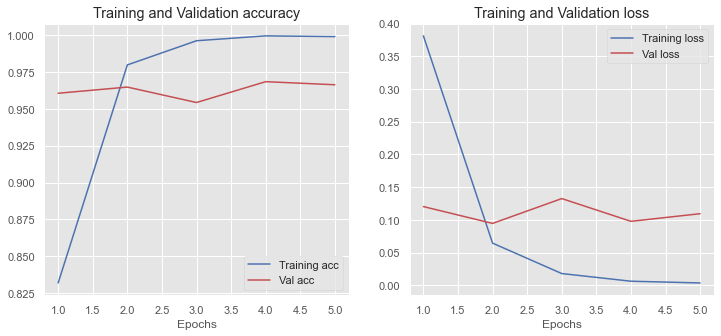

In [117]:
plot_history(history)

In [118]:
# Load weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.02.hdf5")

In [119]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [120]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.00396806],[0],0
1,[0.004070252],[0],0
2,[0.004751593],[0],0
3,[0.89615774],[1],1
4,[0.997642],[1],1


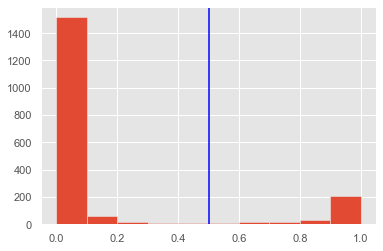

In [121]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1646
           1       0.84      0.92      0.88       260

    accuracy                           0.96      1906
   macro avg       0.91      0.94      0.93      1906
weighted avg       0.97      0.96      0.97      1906



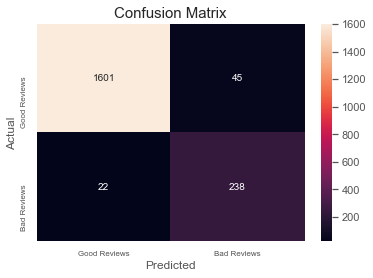

In [122]:
class_conf(y_val,y_pred_class)

In [123]:
shallow = metric_results(y_val,y_pred_class)
shallow

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.964848,0.840989,0.915385,0.876611,0.944023


In [124]:
# What it got wrong
not_correct = ydf[ydf.y != ydf.y_pred_class]
not_correct.head()

,y_prob,y_pred_class,y
39,[0.6312186],[1],0
43,[0.99897486],[1],0
59,[0.57367605],[1],0
60,[0.88859886],[1],0
76,[0.116980314],[0],1


In [125]:
X_val.iloc[76]

'clean would booked last minute stop could see daughter brighton headed patrick tripadvisor review photo looked good arrival found pleasant little tired village pub staff friendly shown room found extremely basic shared bathroom thought would booked ensuite could error would unfair apportion blame asked changing room told one else booked share bathroom possibly reluctant change u would mean preparing another room not know tired push agreed mean route loo shower across stair bar dining room food drink good usual pub menu range hot nicely presented retiring night pub closed dark around 10.30 moonlight flit loo not stressful anticipated shower sounded like powered combine harvester shower screen door propped outside bathroom replaced shower curtain shower holder broken could not change angle water floor bathmat cold soggy would showered not comment standard room room certainly not star I would reluctant return acknowledge age building updating would tricky keeping better order would make 

A long and mixed sentiment review

In [128]:
# Where the model STRONGLY predicted a bad review but was actually rated as good by user
ydf[(ydf.y == 0) & (ydf.y_prob > 0.9)].head()

,y_prob,y_pred_class,y
43,[0.99897486],[1],0
114,[0.9977411],[1],0
557,[0.9069897],[1],0
885,[0.9073645],[1],0
1041,[0.9074623],[1],0


In [129]:
X_val.iloc[1041]

'sweet not always sweet desert menu lacked savory option today kitchen could not even muster couple piece cheese waiter luke professionalism grace personified for staff made party welcome short notice kid not much like pasta sauce plate cleared relish'

The model seems to be right here and the rating wrong, as the sentiment appears to be negative

In [130]:
# Where the model STRONGLY predicted a good review but user rated as bad
ydf[(ydf.y == 1) & (ydf.y_prob < 0.1)].head()

,y_prob,y_pred_class,y
419,[0.02226767],[0],1
1283,[0.040382504],[0],1
1435,[0.019085854],[0],1
1609,[0.05357811],[0],1


In [131]:
X_val.iloc[1609]

'friendly not busy passing helping friend house move laptop pub bit empty bit like atmosphere lemonade driving back portsmouth owner certainly bit drunk think drink profit talking man regular said busy friday night used live music profit low thing keep open listed building status'

Sentiment not clear from this review

In [132]:
model.save("shallowfull.h5")

# Section 6: Shallow Network with dropout

In [133]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid')) 

In [134]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           197536    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 402,593
Trainable params: 402,593
Non-trainable params: 0
_________________________________________________________________
None


In [135]:
# The model will use earlystopping if the valuation loss doesn't decrease after 2 epochs
output_dir = 'model_output/shallow_drop_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [136]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/10
358/358 - 1s - loss: 0.3438 - accuracy: 0.8839 - val_loss: 0.1154 - val_accuracy: 0.9586
Epoch 2/10
358/358 - 1s - loss: 0.0663 - accuracy: 0.9809 - val_loss: 0.1072 - val_accuracy: 0.9633
Epoch 3/10
358/358 - 1s - loss: 0.0191 - accuracy: 0.9974 - val_loss: 0.0993 - val_accuracy: 0.9669
Epoch 4/10
358/358 - 1s - loss: 0.0071 - accuracy: 0.9995 - val_loss: 0.1031 - val_accuracy: 0.9664
Epoch 5/10
358/358 - 1s - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.1120 - val_accuracy: 0.9669
Epoch 6/10
358/358 - 1s - loss: 9.0186e-04 - accuracy: 1.0000 - val_loss: 0.1176 - val_accuracy: 0.9675


In [137]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9675


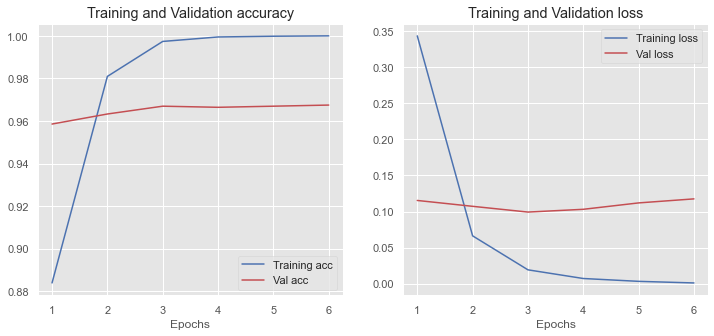

In [138]:
plot_history(history)

In [139]:
# Load weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.03.hdf5") 

In [145]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [146]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0002437532],[0],0
1,[0.00039061904],[0],0
2,[0.001282692],[0],0
3,[0.89921296],[1],1
4,[0.99973124],[1],1


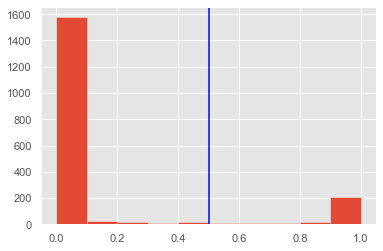

In [147]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1646
           1       0.89      0.87      0.88       260

    accuracy                           0.97      1906
   macro avg       0.93      0.93      0.93      1906
weighted avg       0.97      0.97      0.97      1906



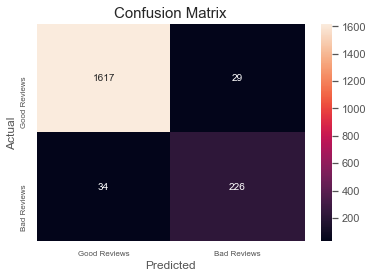

In [149]:
class_conf(y_val,y_pred_class)

In [150]:
dense_1 = metric_results(y_val,y_pred_class)
dense_1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.966946,0.886275,0.869231,0.87767,0.925806


In [152]:
# What it got wrong
not_correct = ydf[ydf.y != ydf.y_pred_class]
not_correct.head()

,y_prob,y_pred_class,y
39,[0.6078924],[1],0
43,[0.9996511],[1],0
60,[0.98806566],[1],0
76,[0.0083526075],[0],1
82,[0.128775],[0],1


In [155]:
# What did it get wrong? Where the model STRONGLY predicted a bad review but was actually rated as good by user
ydf[(ydf.y == 0) & (ydf.y_prob > 0.9)].head()

,y_prob,y_pred_class,y
43,[0.9996511],[1],0
60,[0.98806566],[1],0
114,[0.99871606],[1],0
516,[0.96687],[1],0
932,[0.93437535],[1],0


In [156]:
X_val.iloc[516]

'come love phil collins group adult little one staff great wee kid helped not best behaved luckily not busypeople bother lunch lovely burger vegan burger two camembert starter couple thing improve 1. large glass wine appeared not cooled think better option server would advise bottle not cold want another option room temperature white wine meh fair not tell staff replacement requested given 2. husband wanted cheesecake nope none left changed brownie nope none either ok lovely lunch coffee nope coffee machine broken not presented alternative like get cup tea house finally 0.50 charge added bill charity charity giving money like give charity term not restaurant bill not say anything bill paid others I sure would remove requested find bit bizarre finally phil collins restaurant couple hour serenaded dulcet tone pa two hour hint future not everyone love phil'

Long mixed sentiment reviews

In [157]:
# What did it get wrong? Where the model STRONGLY predicted a good review but user rated as bad
ydf[(ydf.y == 1) & (ydf.y_prob < 0.1)].head()

,y_prob,y_pred_class,y
76,[0.0083526075],[0],1
93,[0.045943677],[0],1
315,[0.054246962],[0],1
419,[0.004540354],[0],1
995,[0.019612998],[0],1


In [158]:
X_val.iloc[995]

'family disaster please everyone visited last not family friendly unsafe place man killed week punch similar incident last help feeling safety site please not visit place closed le'

Sentiment is clearly negative here but the model predicted positive, not clear why

In [159]:
model.save("shallowdropfull.h5")

# Section 7: Deep Network with dropout

In [160]:
# Dense model with 2 hidden dense layers and dropout on each
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='sigmoid')) 

In [161]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 16)           197536    
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [162]:
# The model will use earlystopping if the valuation loss doesn't decrease after 5 epochs
output_dir = 'model_output/deepNN2_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [163]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/10
358/358 - 1s - loss: 0.4140 - accuracy: 0.8416 - val_loss: 0.1698 - val_accuracy: 0.9533
Epoch 2/10
358/358 - 1s - loss: 0.0885 - accuracy: 0.9790 - val_loss: 0.1403 - val_accuracy: 0.9607
Epoch 3/10
358/358 - 1s - loss: 0.0222 - accuracy: 0.9956 - val_loss: 0.1346 - val_accuracy: 0.9622
Epoch 4/10
358/358 - 1s - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.1586 - val_accuracy: 0.9607
Epoch 5/10
358/358 - 1s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1823 - val_accuracy: 0.9612
Epoch 6/10
358/358 - 1s - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1844 - val_accuracy: 0.9643


In [164]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9643


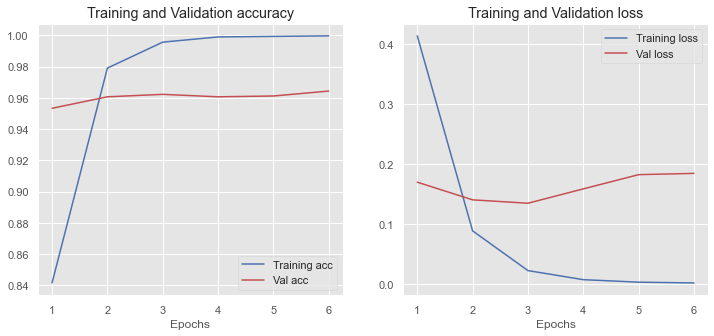

In [165]:
plot_history(history)

In [166]:
# Load weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.03.hdf5") # NOT zero-indexed

In [167]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [172]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[5.7505174e-05],[0],0
1,[5.9702186e-05],[0],0
2,[0.00018587708],[0],0
3,[0.9872099],[1],1
4,[0.9997513],[1],1


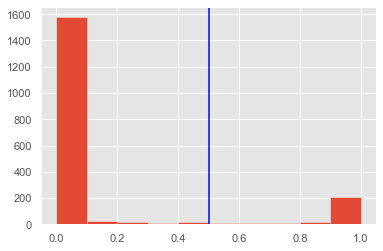

In [173]:
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1646
           1       0.86      0.86      0.86       260

    accuracy                           0.96      1906
   macro avg       0.92      0.92      0.92      1906
weighted avg       0.96      0.96      0.96      1906



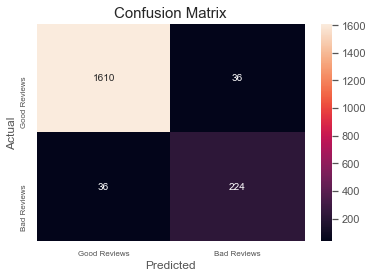

In [169]:
class_conf(y_val,y_pred_class)

In [174]:
dense_2 = metric_results(y_val,y_pred_class)
dense_2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.962225,0.861538,0.861538,0.861538,0.919834


In [175]:
# What it got wrong
not_correct = ydf[ydf.y != ydf.y_pred_class]
not_correct.head()

,y_prob,y_pred_class,y
43,[0.9999663],[1],0
53,[0.8695061],[1],0
59,[0.9844015],[1],0
60,[0.9998144],[1],0
76,[0.015126407],[0],1


In [176]:
# What did it get wrong? Where the model STRONGLY predicted a bad review but was actually rated as good by user
ydf[(ydf.y == 0) & (ydf.y_prob > 0.9)].head()

,y_prob,y_pred_class,y
43,[0.9999663],[1],0
59,[0.9844015],[1],0
60,[0.9998144],[1],0
114,[0.99993575],[1],0
516,[0.995396],[1],0


In [177]:
# What did it get wrong? Where the model strongly predicted a good review but user rated as bad
ydf[(ydf.y == 1) & (ydf.y_prob < 0.1)].head()

,y_prob,y_pred_class,y
76,[0.015126407],[0],1
100,[0.0061165392],[0],1
279,[0.02390176],[0],1
315,[0.053687185],[0],1
416,[0.021241933],[0],1


Looking at the probability histogram, this model is classifying well for both positive and negative reviews, where the high probabilities for each output means the model is certain of the class. The same reviews are causing a problem.

In [178]:
model.save("deepdropfull.h5")

# Section 8: Convolutional Neural Network

Does not consider each word independently. There is some attempt to capture sequences of words by looking for double and triplets of words.

In [210]:
# Set parameters for this model - maxlen 400
input_dim = vocabulary_size #as per Maas et al. (2011)
output_dim = 64
maxlen = 400

# Embedding - padding and truncating at the front of a review
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# Convolutional layer - 256 filters to look for the word embeddings and the window of k_conv set to 3 to pick up trigrams
filters = 256 
kernel_size = 3

# Dense layer: 
n_dense = 256
dropout = 0.2

# Training parameters:
epochs = 10
batch_size = 128

In [211]:
# Create sequences 
X_train_w2 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w2 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [212]:
# Check that the sequence is length 400
X_train_w2.shape

(5718, 400)

In [213]:
# Build model

model = Sequential()

# Embedding layer with dropout on the embedding. Dropout is Spatial so 1d feature maps are dropped rather ind. elements
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

# Convolution layers - 1D as not image data, one dimension of time. 
model.add(Conv1D(filters, kernel_size, activation='relu'))
#model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [214]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 400, 64)           790144    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [215]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [216]:
# The model will use earlystopping if the valuation loss doesn't decrease after 5 epochs
output_dir = 'model_output/CNN_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [217]:
# Model using keras embeddings
history = model.fit(X_train_w2, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w2, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/10
45/45 - 6s - loss: 0.6073 - accuracy: 0.5427 - val_loss: 0.4197 - val_accuracy: 0.7744
Epoch 2/10
45/45 - 6s - loss: 0.2305 - accuracy: 0.9049 - val_loss: 0.1132 - val_accuracy: 0.9601
Epoch 3/10
45/45 - 6s - loss: 0.0786 - accuracy: 0.9729 - val_loss: 0.1291 - val_accuracy: 0.9517
Epoch 4/10
45/45 - 6s - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.1197 - val_accuracy: 0.9596
Epoch 5/10
45/45 - 6s - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.1257 - val_accuracy: 0.9617


In [218]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w2, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w2, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9995
Testing Accuracy:  0.9617


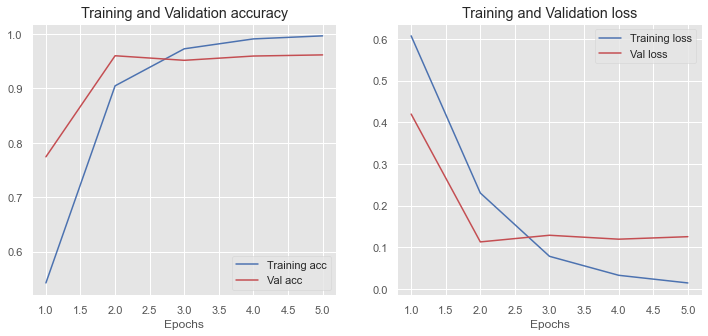

In [219]:
plot_history(history)

In [220]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [221]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w2)
y_pred_class = y_pred_class = (model.predict(X_val_w2) > 0.5).astype("int32")

In [222]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0019523203],[0],0
1,[0.0030799806],[0],0
2,[0.013178378],[0],0
3,[0.9088937],[1],1
4,[0.9977141],[1],1


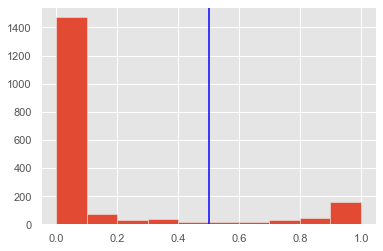

In [223]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1646
           1       0.84      0.88      0.86       260

    accuracy                           0.96      1906
   macro avg       0.91      0.93      0.92      1906
weighted avg       0.96      0.96      0.96      1906



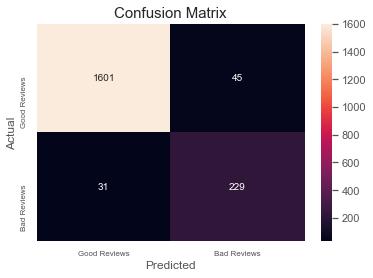

In [224]:
class_conf(y_val,y_pred_class)

In [225]:
conv = metric_results(y_val,y_pred_class)
conv

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.960126,0.835766,0.880769,0.857678,0.926715


In [226]:
# What it got wrong
not_correct = ydf[ydf.y != ydf.y_pred_class]
not_correct.head()

,y_prob,y_pred_class,y
39,[0.6542346],[1],0
43,[0.9883479],[1],0
48,[0.5281787],[1],0
60,[0.6755213],[1],0
82,[0.2825355],[0],1


In [227]:
# What did it get wrong? Where the model STRONGLY predicted a bad review but was actually rated as good by user
ydf[(ydf.y == 0) & (ydf.y_prob > 0.9)].head()

,y_prob,y_pred_class,y
43,[0.9883479],[1],0
114,[0.9867871],[1],0
428,[0.9254073],[1],0
779,[0.9640466],[1],0
1004,[0.9639063],[1],0


In [228]:
# What did it get wrong? Where the model STRONGLY predicted a good review but user rated as bad
ydf[(ydf.y == 1) & (ydf.y_prob < 0.1)].head()

,y_prob,y_pred_class,y
306,[0.080467165],[0],1
315,[0.0061681867],[0],1
802,[0.078921646],[0],1
995,[0.09145397],[0],1
1066,[0.07619855],[0],1


In [229]:
model.save("conv_full.h5")

# Section 9: Recurrent Neural Network

In [230]:
# Set parameters - note maxlen to 100 due to vanishing gradient problem
# simple rnn can backpropagate around 10 words but leave for 100 initially

input_dim = 10000
output_dim = 64
maxlen = 100
n_dim = 64

# Embedding
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# Recurrent layer: 
n_rnn = 256 
drop_rnn = 0.2

# Dense layer: 
#n_dense = 256
#dropout = 0.5

# Training parameters - more epochs needed
epochs = 16
batch_size = 128

In [231]:
# Create sequences 
X_train_w3 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w3 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [232]:
model = Sequential()

# Embedding
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

# Recurrent layer
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))
# model.add(Dense(n_dense, activation='relu')) 
# model.add(Dropout(dropout))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [233]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               82176     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


Note you can reverse the direction if the beginning of the sentence is more important in the review as the later words are given more importance in the model

In [234]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [235]:
output_dir = 'model_output/RNN_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [236]:
# Model using keras embeddings
history = model.fit(X_train_w3, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w3, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/16
45/45 - 4s - loss: 0.7008 - accuracy: 0.4767 - val_loss: 0.7038 - val_accuracy: 0.1364
Epoch 2/16
45/45 - 5s - loss: 0.6793 - accuracy: 0.5331 - val_loss: 0.6438 - val_accuracy: 0.8431
Epoch 3/16
45/45 - 5s - loss: 0.6732 - accuracy: 0.5995 - val_loss: 0.5784 - val_accuracy: 0.8426
Epoch 4/16
45/45 - 5s - loss: 0.6652 - accuracy: 0.6306 - val_loss: 0.7325 - val_accuracy: 0.1380
Epoch 5/16
45/45 - 5s - loss: 0.6565 - accuracy: 0.6712 - val_loss: 0.6432 - val_accuracy: 0.8421
Epoch 6/16
45/45 - 4s - loss: 0.6886 - accuracy: 0.5138 - val_loss: 0.6650 - val_accuracy: 0.8437


In [237]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w3, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w3, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8540
Testing Accuracy:  0.8437


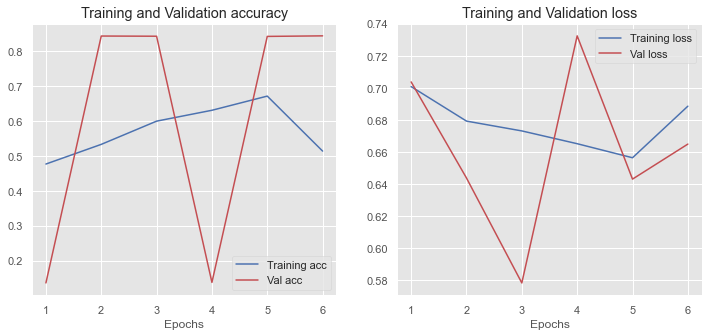

In [238]:
plot_history(history)

Not very successful. Model struggling to learn patterns. Problems with vanishing gradients common with RNNs.

In [239]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [241]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w3)
y_pred_class = y_pred_class = (model.predict(X_val_w3) > 0.5).astype("int32")

In [242]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.4611857],[0],0
1,[0.46118543],[0],0
2,[0.46119],[0],0
3,[0.46023014],[0],1
4,[0.46118543],[0],1


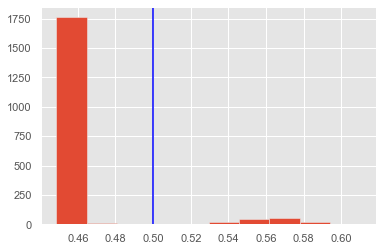

In [243]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1646
           1       0.36      0.18      0.24       260

    accuracy                           0.84      1906
   macro avg       0.62      0.57      0.58      1906
weighted avg       0.81      0.84      0.82      1906



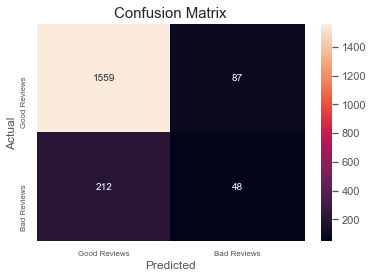

In [244]:
class_conf(y_val,y_pred_class)

In [245]:
rnn = metric_results(y_val,y_pred_class)
rnn

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.843127,0.355556,0.184615,0.243038,0.56588


Gradient diminishes so much that the parameter updates become too small. Simple RNNs rarely used in practice. LSTMs can backpropagate through 100 timesteps

In [246]:
model.save("rnn_full.h5")

# Section 10: LSTM Model

In [247]:
# output directory name:
output_dir = 'model_output/LSTM'

input_dim = 10000 
output_dim = 64
maxlen = 100 # shorter review length
n_dim = 64

# Embedding
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# LSTM layer 
n_lstm = 256 
drop_lstm = 0.2

# Dense layer: 
#n_dense = 256
#dropout = 0.5

# Training parameters:
epochs = 10
batch_size = 128

In [249]:
# Create sequences 
X_train_w4 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w4 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [250]:
model = Sequential()

# Embedding
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

# LSTM layer
model.add(LSTM(n_lstm, dropout=drop_lstm))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
# model.add(Dropout(dropout))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [251]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               328704    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [252]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [253]:
output_dir = 'model_output/LSTM_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [254]:
# Model using keras embeddings
history = model.fit(X_train_w4, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w4, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/10
45/45 - 16s - loss: 0.6777 - accuracy: 0.7165 - val_loss: 0.5631 - val_accuracy: 0.8431
Epoch 2/10
45/45 - 16s - loss: 0.5937 - accuracy: 0.8249 - val_loss: 0.2733 - val_accuracy: 0.9260
Epoch 3/10
45/45 - 16s - loss: 0.4094 - accuracy: 0.8785 - val_loss: 0.4155 - val_accuracy: 0.8379
Epoch 4/10
45/45 - 16s - loss: 0.3509 - accuracy: 0.8393 - val_loss: 0.3803 - val_accuracy: 0.8384
Epoch 5/10
45/45 - 17s - loss: 0.3243 - accuracy: 0.8603 - val_loss: 0.4839 - val_accuracy: 0.8541


In [255]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w4, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w4, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8585
Testing Accuracy:  0.8541


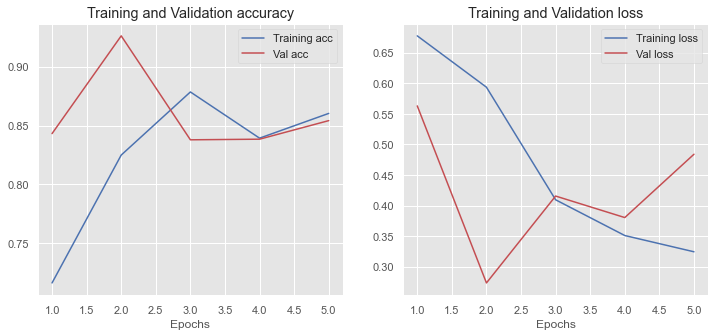

In [256]:
plot_history(history)

In [257]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [258]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w4)
y_pred_class = y_pred_class = (model.predict(X_val_w4) > 0.5).astype("int32")

In [259]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.123606086],[0],0
1,[0.12359148],[0],0
2,[0.123645514],[0],0
3,[0.13254449],[0],1
4,[0.8971248],[1],1


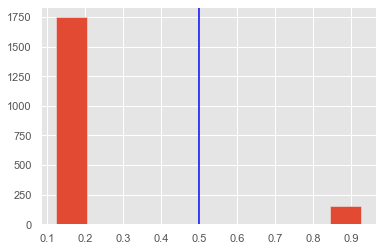

In [260]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1646
           1       0.88      0.53      0.66       260

    accuracy                           0.93      1906
   macro avg       0.90      0.76      0.81      1906
weighted avg       0.92      0.93      0.92      1906



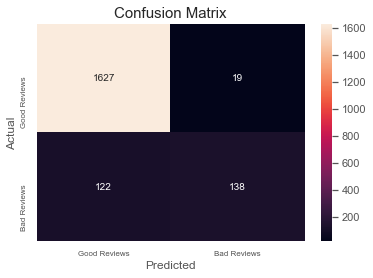

In [261]:
class_conf(y_val,y_pred_class)

In [262]:
lstm = metric_results(y_val,y_pred_class)
lstm

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.926023,0.878981,0.530769,0.661871,0.759613


In [263]:
model.save("lstmfull.h5")

# Section 11: GRU Model

In [264]:
# output directory name:
output_dir = 'model_output/GRU_full'

input_dim = 10000
output_dim = 64
maxlen = 100
n_dim = 64

# Embedding
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# GRU layer
n_gru = 256 
drop_gru = 0.2

# Dense layer: 
#n_dense = 256
#dropout = 0.5

# Training parameters:
epochs = 16
batch_size = 128

In [265]:
# Create sequences 
X_train_w5 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w5 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [266]:
model = Sequential()

# Embedding
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

# GRU layer
model.add(GRU(n_gru, dropout=drop_gru))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
# model.add(Dropout(dropout))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [267]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru (GRU)                    (None, 256)               247296    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 887,553
Trainable params: 887,553
Non-trainable params: 0
_________________________________________________________________


In [268]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [269]:
output_dir = 'model_output/GRU_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [270]:
# Model using keras embeddings
history = model.fit(X_train_w5, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w5, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/16
45/45 - 13s - loss: 0.6802 - accuracy: 0.7707 - val_loss: 0.7054 - val_accuracy: 0.1364
Epoch 2/16
45/45 - 12s - loss: 0.6722 - accuracy: 0.6303 - val_loss: 0.6202 - val_accuracy: 0.8431
Epoch 3/16
45/45 - 12s - loss: 0.6481 - accuracy: 0.8061 - val_loss: 0.5933 - val_accuracy: 0.8547
Epoch 4/16
45/45 - 12s - loss: 0.6470 - accuracy: 0.8445 - val_loss: 0.6943 - val_accuracy: 0.1548
Epoch 5/16
45/45 - 12s - loss: 0.6505 - accuracy: 0.7471 - val_loss: 0.7120 - val_accuracy: 0.1569
Epoch 6/16
45/45 - 13s - loss: 0.4772 - accuracy: 0.8750 - val_loss: 0.4116 - val_accuracy: 0.9014
Epoch 7/16
45/45 - 12s - loss: 0.3804 - accuracy: 0.8526 - val_loss: 0.3378 - val_accuracy: 0.8835
Epoch 8/16
45/45 - 13s - loss: 0.2781 - accuracy: 0.9112 - val_loss: 0.2649 - val_accuracy: 0.9166
Epoch 9/16
45/45 - 12s - loss: 0.2807 - accuracy: 0.8832 - val_loss: 0.2297 - val_accuracy: 0.9229
Epoch 10/16
45/45 - 13s - loss: 0.2209 - accuracy: 0.9568 - val_loss: 0.2725 - val_accuracy: 0.9302
Epoch 11/

In [274]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w5, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w5, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8699
Testing Accuracy:  0.8547


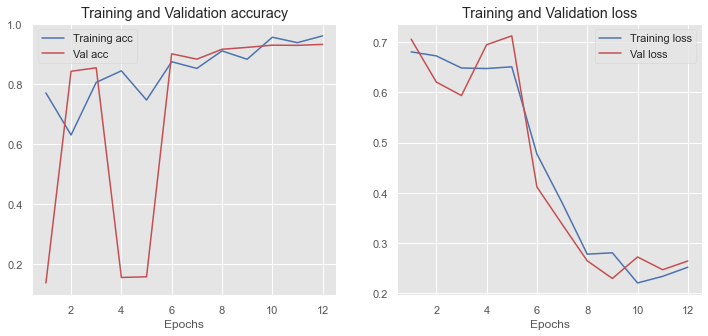

In [275]:
plot_history(history)

In [276]:
model.load_weights(output_dir+"/weights.12.hdf5")

In [277]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w5)
y_pred_class = y_pred_class = (model.predict(X_val_w5) > 0.5).astype("int32")

In [278]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0807946],[0],0
1,[0.08079356],[0],0
2,[0.08079937],[0],0
3,[0.08563933],[0],1
4,[0.9867333],[1],1


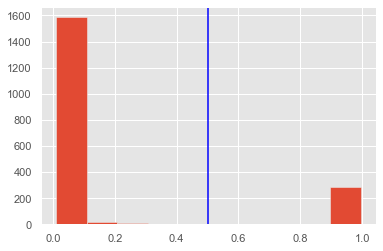

In [279]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1646
           1       0.73      0.82      0.77       260

    accuracy                           0.93      1906
   macro avg       0.85      0.88      0.86      1906
weighted avg       0.94      0.93      0.93      1906



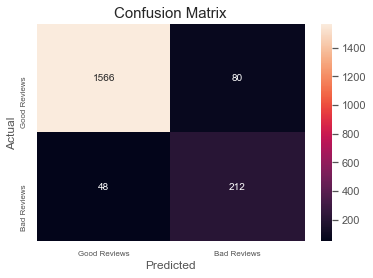

In [280]:
class_conf(y_val,y_pred_class)

In [281]:
gru = metric_results(y_val,y_pred_class)
gru

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.932844,0.726027,0.815385,0.768116,0.883391


In [282]:
model.save("gru_full.h5")

# Section 12: Bidirectional LSTM

Goes backward and forward time steps instead of just backpropagation. Learns patterns before and after a given word.

In [283]:
# output directory name:
output_dir = 'model_output/BID_full'

input_dim = 10000
output_dim = 64
maxlen = 100
n_dim = 64

# Embedding
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

# Dense layer: 
#n_dense = 256
#dropout = 0.5

# Training parameters:
epochs = 16
batch_size = 128

In [284]:
# Create sequences 
X_train_w6 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w6 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [285]:
model = Sequential()

model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [286]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 100, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


In [287]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [288]:
output_dir = 'model_output/BID_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [289]:
# Model using keras embeddings
history = model.fit(X_train_w6, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w6, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/16
45/45 - 45s - loss: 0.5849 - accuracy: 0.8195 - val_loss: 0.3360 - val_accuracy: 0.9066
Epoch 2/16
45/45 - 44s - loss: 0.3206 - accuracy: 0.9147 - val_loss: 0.1677 - val_accuracy: 0.9481
Epoch 3/16
45/45 - 41s - loss: 0.0948 - accuracy: 0.9680 - val_loss: 0.1461 - val_accuracy: 0.9496
Epoch 4/16
45/45 - 40s - loss: 0.0578 - accuracy: 0.9802 - val_loss: 0.1315 - val_accuracy: 0.9586
Epoch 5/16
45/45 - 39s - loss: 0.0343 - accuracy: 0.9909 - val_loss: 0.1144 - val_accuracy: 0.9607
Epoch 6/16
45/45 - 38s - loss: 0.0369 - accuracy: 0.9916 - val_loss: 0.1022 - val_accuracy: 0.9669
Epoch 7/16
45/45 - 38s - loss: 0.0199 - accuracy: 0.9951 - val_loss: 0.1334 - val_accuracy: 0.9617
Epoch 8/16
45/45 - 39s - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.1712 - val_accuracy: 0.9617
Epoch 9/16
45/45 - 40s - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.1361 - val_accuracy: 0.9554


In [290]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w6, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w6, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9976
Testing Accuracy:  0.9554


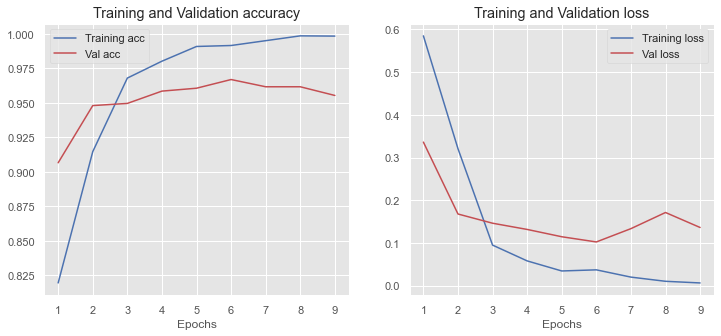

In [291]:
plot_history(history)

In [292]:
model.load_weights(output_dir+"/weights.06.hdf5")

In [293]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w6)
y_pred_class = y_pred_class = (model.predict(X_val_w6) > 0.5).astype("int32")

In [294]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0013504326],[0],0
1,[0.0007430613],[0],0
2,[0.0005129874],[0],0
3,[0.98144037],[1],1
4,[0.99669915],[1],1


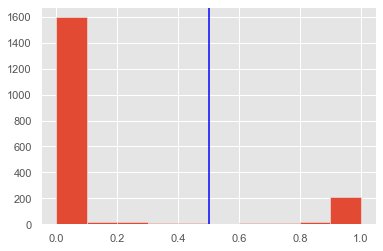

In [295]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1646
           1       0.88      0.87      0.88       260

    accuracy                           0.97      1906
   macro avg       0.93      0.93      0.93      1906
weighted avg       0.97      0.97      0.97      1906



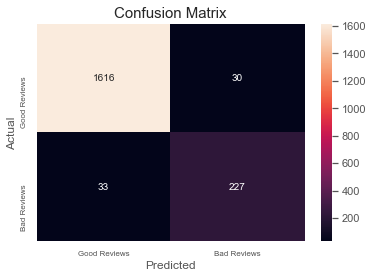

In [296]:
class_conf(y_val,y_pred_class)

In [297]:
bid = metric_results(y_val,y_pred_class)
bid

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.966946,0.883268,0.873077,0.878143,0.927425


In [298]:
model.save("bidfull.h5")

# Section 13: Stacked LSTM

In [299]:
input_dim = 10000
output_dim = 64
maxlen = 100
n_dim = 64

# Embedding
pad_type = 'post'
truncating = 'post'
drop_embed = 0.2

# LSTM layers:
n_lstm_1 = 64
n_lstm_2 = 64 
drop_lstm = 0.2

# Dense layer: 
#n_dense = 256
#dropout = 0.5

# Training parameters:
epochs = 16
batch_size = 128

In [300]:
# Create sequences 
X_train_w7 = pad_sequences(np.array(X_train_s,dtype = "object"), padding=pad_type, truncating = truncating,maxlen = maxlen)
X_val_w7 = pad_sequences(np.array(X_val_s,dtype = "object"), padding=pad_type, truncating = truncating, maxlen=maxlen)

In [301]:
model = Sequential()

model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, return_sequences=True))) # retain temporal dimension
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid'))

In [302]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 804,993
Trainable params: 804,993
Non-trainable params: 0
_________________________________________________________________


In [303]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [304]:
output_dir = 'model_output/SLSTM_full'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3),modelcheckpoint]

In [305]:
# Model using keras embeddings
history = model.fit(X_train_w7, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w7, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/16
45/45 - 36s - loss: 0.5229 - accuracy: 0.8538 - val_loss: 0.1854 - val_accuracy: 0.9444
Epoch 2/16
45/45 - 42s - loss: 0.1500 - accuracy: 0.9636 - val_loss: 0.1385 - val_accuracy: 0.9523
Epoch 3/16
45/45 - 42s - loss: 0.0684 - accuracy: 0.9832 - val_loss: 0.1286 - val_accuracy: 0.9580
Epoch 4/16
45/45 - 43s - loss: 0.0434 - accuracy: 0.9907 - val_loss: 0.1176 - val_accuracy: 0.9565
Epoch 5/16
45/45 - 42s - loss: 0.0300 - accuracy: 0.9927 - val_loss: 0.2819 - val_accuracy: 0.9412
Epoch 6/16
45/45 - 43s - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.1530 - val_accuracy: 0.9675
Epoch 7/16
45/45 - 42s - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.2097 - val_accuracy: 0.9470


In [306]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w7, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w7, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9918
Testing Accuracy:  0.9470


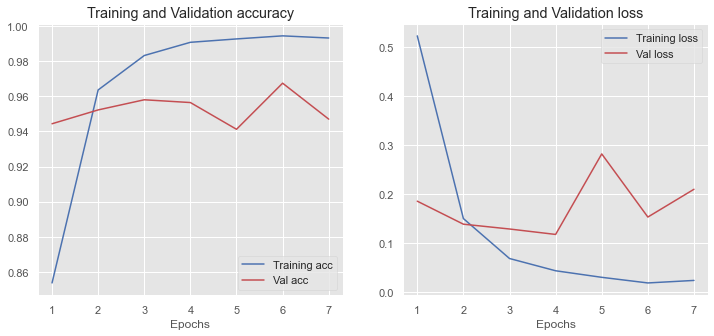

In [307]:
plot_history(history)

In [315]:
model.load_weights(output_dir+"/weights.06.hdf5") 

In [316]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w7)
y_pred_class = y_pred_class = (model.predict(X_val_w7) > 0.5).astype("int32")

In [317]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.0014462471],[0],0
1,[0.0014331043],[0],0
2,[0.0014646053],[0],0
3,[0.77871835],[1],1
4,[0.9991692],[1],1


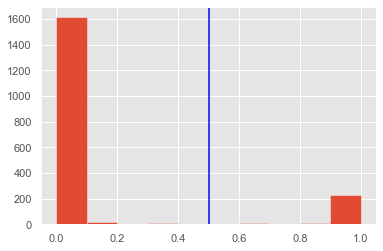

In [318]:
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1646
           1       0.88      0.88      0.88       260

    accuracy                           0.97      1906
   macro avg       0.93      0.93      0.93      1906
weighted avg       0.97      0.97      0.97      1906



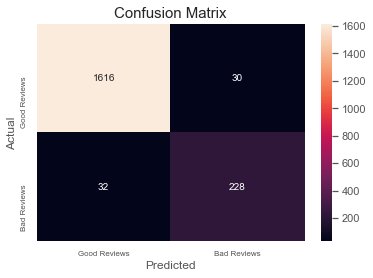

In [319]:
class_conf(y_val,y_pred_class)

In [320]:
stack = metric_results(y_val,y_pred_class)
stack

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.967471,0.883721,0.876923,0.880309,0.929349


In [321]:
model.save("stackfull.h5")

# Section 14: Summary of Validation Set Metrics

In [327]:
models = ["Simple MLP","Shallow NN","Shallow_dropout","Deep_dropout", "Conv","RNN","LSTM","GRU","Bi-LSTM","Stacked Bi-LSTM"]
summary_neural2 = pd.concat([simple_model,shallow,dense_1,dense_2,conv,rnn,lstm,gru,bid,stack])
summary_neural2.set_index([models],inplace = True)
summary_neural2.to_csv("summary_nets_fulldata.csv")
summary_neural2.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Simple MLP,0.967471,0.848592,0.926923,0.886029,0.950400
Stacked Bi-LSTM,0.967471,0.883721,0.876923,0.880309,0.929349
Shallow_dropout,0.966946,0.886275,0.869231,0.877670,0.925806
Bi-LSTM,0.966946,0.883268,0.873077,0.878143,0.927425
Shallow NN,0.964848,0.840989,0.915385,0.876611,0.944023
Deep_dropout,0.962225,0.861538,0.861538,0.861538,0.919834
Conv,0.960126,0.835766,0.880769,0.857678,0.926715
GRU,0.932844,0.726027,0.815385,0.768116,0.883391
LSTM,0.926023,0.878981,0.530769,0.661871,0.759613
RNN,0.843127,0.355556,0.184615,0.243038,0.565880


In [323]:
# Sort by AUROC score
summary_neural2.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Simple MLP,0.967471,0.848592,0.926923,0.886029,0.950400
Shallow NN,0.964848,0.840989,0.915385,0.876611,0.944023
Stacked Bi-LSTM,0.967471,0.883721,0.876923,0.880309,0.929349
Bi-LSTM,0.966946,0.883268,0.873077,0.878143,0.927425
Conv,0.960126,0.835766,0.880769,0.857678,0.926715
Shallow_dropout,0.966946,0.886275,0.869231,0.877670,0.925806
Deep_dropout,0.962225,0.861538,0.861538,0.861538,0.919834
GRU,0.932844,0.726027,0.815385,0.768116,0.883391
LSTM,0.926023,0.878981,0.530769,0.661871,0.759613
RNN,0.843127,0.355556,0.184615,0.243038,0.565880


In [325]:
# Sort by F1 score (precision/recall)
summary_neural2.sort_values(by = "F1",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Simple MLP,0.967471,0.848592,0.926923,0.886029,0.950400
Stacked Bi-LSTM,0.967471,0.883721,0.876923,0.880309,0.929349
Bi-LSTM,0.966946,0.883268,0.873077,0.878143,0.927425
Shallow_dropout,0.966946,0.886275,0.869231,0.877670,0.925806
Shallow NN,0.964848,0.840989,0.915385,0.876611,0.944023
Deep_dropout,0.962225,0.861538,0.861538,0.861538,0.919834
Conv,0.960126,0.835766,0.880769,0.857678,0.926715
GRU,0.932844,0.726027,0.815385,0.768116,0.883391
LSTM,0.926023,0.878981,0.530769,0.661871,0.759613
RNN,0.843127,0.355556,0.184615,0.243038,0.565880


In [328]:
# Sort by Recall
summary_neural2.sort_values(by = "Recall",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Simple MLP,0.967471,0.848592,0.926923,0.886029,0.950400
Shallow NN,0.964848,0.840989,0.915385,0.876611,0.944023
Conv,0.960126,0.835766,0.880769,0.857678,0.926715
Stacked Bi-LSTM,0.967471,0.883721,0.876923,0.880309,0.929349
Bi-LSTM,0.966946,0.883268,0.873077,0.878143,0.927425
Shallow_dropout,0.966946,0.886275,0.869231,0.877670,0.925806
Deep_dropout,0.962225,0.861538,0.861538,0.861538,0.919834
GRU,0.932844,0.726027,0.815385,0.768116,0.883391
LSTM,0.926023,0.878981,0.530769,0.661871,0.759613
RNN,0.843127,0.355556,0.184615,0.243038,0.565880


* The best model on all metrics was the simple multi-layer perceptron but it did not do better than the machine learning models
* Much more data is likely needed for these models to perform at their best and the dataset is quite small at only 10,000 reviews
* However, the neural networks did not need as much text processing
* The more complicated models classified the reviews into positive and negative very cleanly, with most datapoints classified with 0 or 1 probability compared to the simpler models. 
* The complex models did not generalise so well to the validation datasets